### Retrieval Augmented Diffusion Model for Time-Series Forecasting

Authors: </br>
Valerio Baldi 1940729 </br>
Saverio Dieni 1946039 </br>

Selected paper: <br/>
[**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)

# References

Paper: [**Retrieval-Augmented Diffusion Models for Time Series Forecasting**](https://openreview.net/pdf?id=dRJJt0Ji48)<br/>
Dataset: [**HouseTS Dataset from Kaggle**](https://www.kaggle.com/datasets/shengkunwang/housets-dataset)

# Project aim and paper description

The project aims to implement a generative model for time-series forecasting, applying it to a house-price and socioeconomic dataset. As demostrated in the paper, the model improves the general diffusion model framework by adding embedding-based retrieval mechanism that retrieves series sharing similar patterns from a reference database. It improves the model generation by exploiting the references, to overcome the lack of guidance in the forecasting process, leading to more accurate and context-aware forecasts.<br/>
In particular the framework proposed in the paper suggested to use a pre-trained encoder for time-series. The encoder compresses time-series, simplifying the task of finding series with similar patterns. It is also produced an index of the embeddings for a fast retrieval of the reference. </br> 

# Theoretical background and key concepts

Retrieval-Augmented Time-Series Diffusion (RATD) is based on the theory of diffusion probabilistic models, which are generative models that learn to reverse a Markovian forward noising process. These models are designed to learn the reverse of a forward noising process, where an original sample x0​ is progressively corrupted into xT​. <br/>

The model takes as input a time-series, where the tail of the series is completely filled with noise, and the model is able to recostruct the original signal, exploiting the context retrieved by the head of the series, the references and the side information.</br>

As previously described, the references were found by looking at the k-nearest neighbours in a lower dimensional space, with respect to the head of the series, and we take as references the tails of those neighbours. <br/>

The side information is obtained by concatenating the temporal embeddings with the feature embeddings, where the temporal embeddings are sinusoidal positional embeddings, while the feature embeddings are learnable positional embeddings.  

These embeddings are concatenated and fed into attention modules based on a Transformer architecture.

The model adopts a lightweight attention mechanism inspired by CSDI, consisting of alternating temporal and feature Transformer layers. By using linear attention, RATD is able to handle long sequences and large datasets more efficiently.

# Reproducibility

We both launched this notebook on our machines and on Kaggle notebooks. Before starting the process is required to import all the modules defined in the import section. It is also necessary to have available the auto-encoder for housets defined in the notebook "autoencoder_for_housets.ipynb". You can direclty find the pre-trained auto-encoder model in the folder "models", with the name "encoder.pth".

# Import

In [1]:
pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 56.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install linear-attention-transformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [3]:
import torch
import torch.nn as nn
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from linear_attention_transformer import LinearAttentionTransformer
import math 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import faiss
from IPython.display import display
import random
from sklearn.utils import shuffle

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # conflict between faiss and pytorch libraries 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data extraction and preprocessing

In this section we extract the time series from the CSV file. <br/>
The original dataset contains entries of the form <date, median_sale_price, median_list_price, median_ppsf, median_list_ppsf, homes_sold, pending_sales, new_listings, inventory, median_dom, avg_sale_to_list, sold_above_list, off_market_in_two_weeks, city, zipcode, year, bank, bus, hospital, mall, park, restaurant, school, station, supermarket, Total Population, Median Age, Per Capita Income, Total Families Below Poverty, Total Housing Units, Median Rent,Median Home Value, Total Labor Force, Unemployed Population, Total School Age Population, Total School Enrollment, Median Commute Time, price, city_full>, where the combination of <zipcode, year> is a key for the dataset. 
The HouseTS dataset contains also satellite images, grouped by zipocode in different folders. For this reason we decided to keep only the entries relative to zones linked to images. 
The zipcode is a representative value for each zone of Washington.</br>
We extract time series of length of 24 steps (24 months), where our final aim is to predict the last 12 timesteps given the previous 12s. </br>
As preprocessing we dropped non relevant features in this simplified scenario, and we also extracted metadata: zipcode, timestamp, year.  

In [5]:
window_length = 24 # 12 known timesteps, the last 12 timestemps to be predicted
step_size = 1

In [6]:
csv_file = "/kaggle/input/housets/HouseTS_with_images.csv"
df = pd.read_csv(csv_file)

df = df.drop(columns=['city', 'city_full'])

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['zipcode', 'date']).reset_index(drop=True)

feature_columns = [col for col in df.columns if col not in ['date', 'zipcode', 'year']]
feature_index_mapping = {i: col for i, col in enumerate(feature_columns)}

print("Feature index mapping:")
print(feature_index_mapping)

all_windows = []
all_meta = []

def extract_windows(df_sub, window_len, step):
    windows = []
    for i in range(0, len(df_sub) - window_len + 1, step):
        window = df_sub.iloc[i:i+window_len].drop(columns=['date', 'zipcode', 'year']).values
        windows.append(window)
    return np.array(windows)

# Group by zipcode
for zipcode, group in df.groupby('zipcode'):
    group = group.reset_index(drop=True)
    if len(group) < window_length:
        continue

    windows = extract_windows(group, window_length, step_size)
    all_windows.append(windows)

    # Save metadata
    window_meta = [(zipcode, group.loc[i, 'date'], group.loc[i, 'year']) for i in range(len(group) - window_length + 1)]
    all_meta.extend(window_meta)

# Concatenate all the windows
X = np.vstack(all_windows)  # shape: (num_samples, window_length, num_features)

print("Shape of X:", X.shape)
print("Number of metadata entries:", len(all_meta))
print("Metadata example:", all_meta[0])

Feature index mapping:
{0: 'median_sale_price', 1: 'median_list_price', 2: 'median_ppsf', 3: 'median_list_ppsf', 4: 'homes_sold', 5: 'pending_sales', 6: 'new_listings', 7: 'inventory', 8: 'median_dom', 9: 'avg_sale_to_list', 10: 'sold_above_list', 11: 'off_market_in_two_weeks', 12: 'bank', 13: 'bus', 14: 'hospital', 15: 'mall', 16: 'park', 17: 'restaurant', 18: 'school', 19: 'station', 20: 'supermarket', 21: 'Total Population', 22: 'Median Age', 23: 'Per Capita Income', 24: 'Total Families Below Poverty', 25: 'Total Housing Units', 26: 'Median Rent', 27: 'Median Home Value', 28: 'Total Labor Force', 29: 'Unemployed Population', 30: 'Total School Age Population', 31: 'Total School Enrollment', 32: 'Median Commute Time', 33: 'price'}
Shape of X: (36652, 24, 34)
Number of metadata entries: 36652
Metadata example: (20001, Timestamp('2012-03-31 00:00:00'), 2012)


We shuffled the dataset fixing the seed for replication purposes, then we splitted the dtaset for the training, evaluation and testing, respectively with a proportion 70%, 10% 20%. We normalized the datasets, according to the training dataset. Finally we created the DataLoaders, with a batch size of 32. 

In [7]:
X, all_meta = shuffle(X, all_meta, random_state=626)

train_size = int(0.7 * len(X))
val_size = int(0.1 * len(X))
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

meta_train = all_meta[:train_size]
meta_val = all_meta[train_size:train_size + val_size]
meta_test = all_meta[train_size + val_size:]

In [8]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, meta, seq_len=None):
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.meta = meta  # [(zipcode, date, year)]
        self.seq_len = seq_len or X.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # shape: (seq_len, num_features)

        zipcode, date, year = self.meta[idx]

        # Convert date to UNIX timestamp and repeat
        timestamp = int(pd.Timestamp(date).timestamp())
        timestamps = torch.full((self.seq_len,), timestamp, dtype=torch.long)

        # Repeat year
        year_tensor = torch.full((self.seq_len,), year, dtype=torch.long)

        return x, timestamps, year_tensor

In [9]:
# Compute the statistics of the train dataset and normalize with respect to it 
mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
std = X_train.std(axis=(0, 1), keepdims=True)

X_train_norm = (X_train - mean) / std
X_val_norm = (X_val - mean) / std
X_test_norm = (X_test - mean) / std

train_dataset = TimeSeriesDataset(X_train_norm, meta_train)
val_dataset = TimeSeriesDataset(X_val_norm, meta_val)
test_dataset = TimeSeriesDataset(X_test_norm, meta_test)

X_train_tensor =  train_dataset.X

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Retrieval Database

We reloaded the pre-trained encoder-decoder to embed the train dataset and build an efficient retrieval database for top k nearest neighbours search. 

In [10]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation  # full causal
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)

        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)

        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2,
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        if out.shape != res.shape:
            # Align time dimension by cropping the residual (this might be necessary in some edge cases)
            min_len = min(out.size(-1), res.size(-1))
            out = out[..., :min_len]
            res = res[..., :min_len]
        return self.relu(out + res)


In [11]:
# Encoder
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_dim if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))
        self.tcn = nn.Sequential(*layers)

        # Projection from [B, C, T] to [B, emb_dim]
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.project = nn.Linear(num_channels[-1], emb_dim)

    def forward(self, x):
        # x: [B, T, D] → [B, D, T]
        x = x.permute(0, 2, 1)
        x = self.tcn(x)  # [B, C, T]
        x = self.pool(x).squeeze(-1)  # [B, C]
        x = self.project(x)  # [B, emb_dim]
        return x

# Decoder
class TCNDecoder(nn.Module):
    def __init__(self, emb_dim, output_dim, seq_len, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.output_dim = output_dim

        # Project embedding back to a sequence shape: [B, C, T]
        self.expand = nn.Linear(emb_dim, num_channels[0] * seq_len)

        layers = []
        for i in range(len(num_channels) - 1):
            in_ch = num_channels[i]
            out_ch = num_channels[i + 1]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))

        self.tcn = nn.Sequential(*layers)
        self.out_proj = nn.Conv1d(num_channels[-1], output_dim, kernel_size=1)

    def forward(self, x):
        # x: [B, emb_dim] → [B, C0, T]
        x = self.expand(x)  # [B, C0 * T]
        x = x.view(x.size(0), -1, self.seq_len)  # [B, C0, T]
        x = self.tcn(x)  # [B, Cn, T]
        x = self.out_proj(x)  # [B, D, T]
        return x.permute(0, 2, 1)  # [B, T, D]

In [12]:
class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.encoder = TCNEncoder(input_dim, emb_dim, channels, kernel_size, dropout)
        self.decoder = TCNDecoder(emb_dim, input_dim, seq_len, channels[::-1], kernel_size, dropout)

    def forward(self, x, only_encoder = False):
        # x: [B, T, D]
        z = self.encoder(x)       # [B, emb_dim]
        if only_encoder:
            return z
        x_recon = self.decoder(z) # [B, T, D]
        return x_recon


In [13]:
encoder_path = "/kaggle/input/housets_encoder/pytorch/default/1/encoder.pth"
T, D = 12, 34
emb_dim = 64
channels = [32, 64, 128]

encoder_loaded = TCNAutoencoder(input_dim=D, emb_dim=emb_dim, seq_len=T, channels=channels)

encoder_loaded.load_state_dict(torch.load(encoder_path, map_location=device))

encoder_loaded.to(device)

encoder_loaded.eval()

print("Models reloaded successfully.")

Models reloaded successfully.


As indicated in the paper, we build the retrieval database starting from the train dataset. In particular for each time series in the train dataset, the retrieval database DR_emb contains a couple (embedding, target), where embedding is obtained as the result of the encoder on the head of the series, in our case we consider the first 12 timesteps, and the target is simply the tail of the series, in our case of length 12. </br>
We want to use the retrieval database Dr_emb to find the top k nearest neighbours, to use as a reference for the prediction model. At this purpose we indexed the database using the FAISS implementation, which is very effective for large datasets, so to search fast even increasing the number of samples.  

In [14]:
@torch.no_grad()
def build_retrieval_database(dataset, encoder, n, h, device):
    """
    Build the retrieval database DR_emb as a list of tuples (embedding, target).
    
    Args:
        dataset: tensor (N, n+h, D)
        encoder: pre-trained model
        n: head of the sequence
        h: len of the target

    Returns:
        List of tuples: [(embedding_i, target_i)]
    """
    encoder.eval()
    dataset = dataset.to(device)
    emb_list = []
    for i in range(dataset.shape[0]):
        x = dataset[i:i+1, :n, :]        # (1, n, D)
        y = dataset[i, n:n+h, :].clone() # (h, D)
        emb = encoder(x, only_encoder = True)                 # (1, embedding_dim)
        emb_list.append((emb.squeeze(0).cpu(), y.cpu()))
    return emb_list


In [15]:
def build_faiss_index(retrieval_db, use_gpu=False):
    """
    Build a FAISS index starting from the retrieval_db.

    Args:
        retrieval_db: list of (embedding, target)

    Returns:
        index: FAISS index
        targets: tensor (N, h, D)
    """
    # Extract embeddings e targets
    embeddings = torch.stack([emb for (emb, _) in retrieval_db])  # (N, embdim)
    targets = torch.stack([tgt for (_, tgt) in retrieval_db])      # (N, h, D)

    emb_dim = embeddings.shape[1]
    embeddings_np = embeddings.numpy().astype('float32')

    # Build the index (FlatL2 = exact KNN, IVFFlat = approximated KNN)
    index = faiss.IndexFlatL2(emb_dim) 
    if use_gpu:
        res = faiss.StandardGpuResources()
        index = faiss.index_cpu_to_gpu(res, 0, index)

    index.add(embeddings_np)  # index all the embeddings
    return index, targets

In [16]:
def retrieve_knn(xH, encoder, faiss_index, targets_db, k, device):
    """
    KNN using the FAISS index.

    Args:
        xH: tensor (B, n, D)
        encoder: pre-trained encoder
        faiss_index: index FAISS
        targets_db: tensor (N, h, D)
        k: number of neighbours 

    Returns:
        xR: tensor (B, k, h, D)
    """
    encoder.eval()
    with torch.no_grad():
        vH = encoder(xH.to(device), only_encoder = True)  # (B, emb_dim)

    vHnp = vH.cpu().numpy().astype('float32')
    _, indices = faiss_index.search(vHnp, k)  # (B, k)

    indices_torch = torch.from_numpy(indices)  # (B, k)
    xR = targets_db[indices_torch]  # (B, k, h, D)
    return xR


In [17]:
for p in encoder_loaded.parameters():
    p.requires_grad = False

retrieval_db = build_retrieval_database(X_train_tensor, encoder_loaded, n=12, h=12, device=device)
faiss_index, xr_target = build_faiss_index(retrieval_db)

# Model

In this section we developed the RATD model according to the descriptions and the graphical representations reported in the paper.</br> </br>
<img src="ratd_architecture.png"> </br></br>
We started from the implementation of the module regarding the side information (time embeddings + feature embeddings) and the diffusion timestep embeddings. 
Then we implemented the other blocks lik the RMA (Reference Modulated Attention) module, the Time and the Feature Tranformers, starting from the implementation provived by LinearAttentionTransformer, and finally the GAU (Gated Activation Unit) module. </br>
We composed all together these blocks in the module RATDLayer, that includes all the computations done in a single step of the model. Lastly we implemented the complete RATD model, by stacking the layers and applying additonal computations adding the noise to the input, initializing the side information and the diffiusion timestep embedding, and finally processing the results of each layer.    

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
class CausalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, bias=True, mask = None):
        super().__init__()
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size

        # Standard Conv2d layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, dilation=dilation, bias=bias)

        # Build causal mask
        if mask is None:
            mask = self._build_causal_mask(kernel_size)
        self.register_buffer("mask", mask)

    def _build_causal_mask(self, kernel_size):
        """Create a causal mask of shape (kH, kW)."""
        kH, kW = kernel_size
        mask = torch.ones(kH, kW, dtype=torch.float32)
        return mask

    def forward(self, x):
        # Apply mask to conv weights before convolution
        # Weight shape: (out_channels, in_channels, kH, kW)
        w = self.conv.weight * self.mask
        return F.conv2d(x, w, bias=self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

In [20]:
class SideInformation(nn.Module):
    def __init__(self, num_features: int, time_dim: int = 32, feat_dim: int = 16, base: int = 10000):
        """
        time_dim: dimension of the sinusoidal time embeddings
        feat_dim: dimension of the feature embeddings
        """
        super().__init__()
        self.num_features = num_features
        self.time_dim = time_dim
        self.feat_dim = feat_dim
        self.total_dim = time_dim + feat_dim  # 144, as in the paper 
        self.base = base

        # Learnable feature embedding: (num_features, feat_dim)
        self.feature_embedding = nn.Parameter(torch.randn(num_features, feat_dim))

    def forward(self, timestamps: torch.Tensor) -> torch.Tensor:
        """
        timestamps: (batch, seq_len)
        Returns:
            side_info Is: (batch, total_dim, seq_len, num_features)
        """
        batch_size, seq_len = timestamps.shape
        device = timestamps.device

        # Temporal sinusoidal embedding 
        positions = timestamps.float().unsqueeze(-1)  # (batch, seq_len, 1)
        div_term = torch.exp(
            torch.arange(0, self.time_dim, 2, device=device) * -(np.log(self.base) / self.time_dim)
        )  # (time_dim/2,)
        sin_embed = torch.sin(positions * div_term)  # (batch, seq_len, time_dim/2)
        cos_embed = torch.cos(positions * div_term)  # (batch, seq_len, time_dim/2)
        time_emb = torch.cat([sin_embed, cos_embed], dim=-1)  # (batch, seq_len, time_dim)

        # Feature embedding learnable 
        feat_emb = self.feature_embedding.unsqueeze(0).unsqueeze(0)  # (1, 1, num_features, feat_dim)
        feat_emb = feat_emb.expand(batch_size, seq_len, -1, -1)      # (batch, seq_len, num_features, feat_dim)

        # Expand time embedding to match num_features 
        time_emb = time_emb.unsqueeze(2).expand(-1, -1, self.num_features, -1)  # (batch, seq_len, num_features, time_dim)

        # Concatenate 
        side_info = torch.cat([time_emb, feat_emb], dim=-1)  # (batch, seq_len, num_features, total_dim)

        # Permute: (batch, total_dim, seq_len, num_features)
        side_info = side_info.permute(0, 3, 1, 2)

        return side_info  # Is


The RMA module was built following the structure provided in the paper, as shown in the image below:</br></br>
<img src="RMA_module.png"></br></br>
The module use attention on the references and on the side information to guide the generation process.

In [21]:
class RMA(nn.Module): 
    def __init__(self, input_dim, inner_dim=32):
        super().__init__()
        self.q_proj = nn.Linear(input_dim, inner_dim)
        self.k_proj = nn.Linear(2 * input_dim, inner_dim)
        self.v_proj = nn.Linear(3 * input_dim, inner_dim)
        self.out = nn.Linear(inner_dim, input_dim)

    def forward(self, x, side_info, xr=None, causal=False):
        """
        x:         (B, C, T, D)
        xr:        Optional. (B, C, T, D) or None
        side_info: (B, C, T, D)
        Returns:
        Z: (B, C, T, D)
        """
        B, C, T, D = x.shape

        # If xr is None, use zero tensor
        if xr is None:
            xr = torch.zeros_like(x)

        if causal:
            # Causal mask: only x_{<t}, exclude x_t itself
            mask = torch.tril(torch.ones(T, T, device=x.device), diagonal=0)  # (T, T)
        
            # Reshape for matmul: (B, C, D, T)
            x = x.permute(0, 1, 3, 2)  # (B, C, D, T)
        
            # Apply mask: (B, C, D, T) x (T, T) -> (B, C, D, T)
            x = torch.matmul(x, mask)  # each t gets sum of x_{<t}
        
            # Reshape back to (B, C, T, D)
            x = x.permute(0, 1, 3, 2)


        # 1. Concat references and side_info: (B, C, T, D)
        k_input = torch.cat([xr, side_info], dim=-1)
        v_input = torch.cat([x, k_input], dim=-1)

        # 2. Linear projections
        Q = self.q_proj(x)  # (B, C, T, D_inner)
        K_proj = self.k_proj(k_input)  # (B, C, T, D_inner)
        V_proj = self.v_proj(v_input)  # (B, C, T, D_inner)

        # 3. Rearrange K and V for matmul
        # shape: (B, T, C, D_inner)
        K_flat = K_proj.permute(0, 2, 1, 3)
        V_flat = V_proj.permute(0, 2, 1, 3).reshape(B*T, C, V_proj.shape[-1])

        # 4. Attention computation
        # softmax over C dimension (i.e., across references + side info)
        A = torch.softmax(K_flat, dim=2)  # (B, T, C, D_inner)

        # compute A^T V: (B*T, D_inner, C) X (B*T, C, D_inner)
        A_T = A.permute(0, 1, 3, 2).reshape(B*T, A.shape[-1], C)  # (B*T, D_inner, C) 
        attn_matrix = torch.bmm(A_T, V_flat)  # (B*T, D_inner, D_inner)

        # 5. Q × A: (B*C, T, D_inner) x (B*T, D_inner, D_inner)
        Q = Q.permute(0, 2, 1, 3).reshape(B*T, C, Q.shape[-1])  # (B*T, C, D_inner)
        Z = torch.bmm(Q, attn_matrix)  # (B*T, C, D_inner)

        Z = self.out(Z) # (B*T, C, D)

        # Rearrange back: (B, C, T, D)
        Z = Z.reshape(B, T, C, Z.shape[-1]).permute(0, 2, 1, 3)

        return Z, attn_matrix


In [22]:
# test modules

B, T, D = 32, 12, 34
C = 16
K = 3
side_module = SideInformation(num_features=D)
timestamps = torch.randint(18000, 20000, (B, T))
side_info = side_module(timestamps)  # (B, 144, T, D)

x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, C, T, D)

rma = RMA(input_dim=D)

out = rma(x, side_info, xr, causal=True)[0]

print("Output shape:", out.shape)  # (B, T, inner_dim)

Output shape: torch.Size([32, 16, 12, 34])


In [23]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=4):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 256,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 2, 1, 3).reshape(B * T, C, D) # (B * T, C, D)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, T, C, D).permute(0, 2, 1, 3) # (B, C, T, D)
        return x


In [24]:
class FeatureTransformer(nn.Module):
    def __init__(self, d_model=128, n_heads=4):
        super().__init__()
        self.transformer = LinearAttentionTransformer(
            dim=d_model,
            depth=1,
            heads=n_heads,
            max_seq_len = 256,
            causal = True
        )

    def forward(self, x):
        # x: (B, C, T, D)
        B, C, T, D = x.shape
        # Permute and reshape
        x = x.permute(0, 3, 1, 2).reshape(B * D, C, T) # (B * D, C, T)
        # Permute, apply the transformation and then permute back
        x = self.transformer(x.permute(0, 2, 1)).permute(0, 2, 1) # (B * T, C, D)
        # Reshape and permute to return to the original shape
        x = x.reshape(B, D, C, T).permute(0, 2, 3, 1) # (B, C, T, D)
        return x


In [25]:
class LearnableDiffusionTimestepEmbedding(nn.Module):
    def __init__(self, num_timesteps: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_timesteps, embedding_dim)

    def forward(self, timesteps: torch.Tensor):
        """
        timesteps: (batch_size,) tensors of integers ∈ [0, num_timesteps)
        """
        return self.embedding(timesteps)  # (batch_size, embedding_dim)


In [26]:
# Gated Activation Unit
class GAU(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.projection = CausalConv2d(channels, 2 * channels, kernel_size=3, padding=1)

    def forward(self, x):
        """"
        input: x (B, C, T, D)
        output: x (B, C, T, D)
        """
        # Doubling the number of channels 
        x = self.projection(x)  # (B, 2*C, T, D)
        # Split x in 2 chunks
        gate, filter = torch.chunk(x, 2, dim=1)  # each of them with shape (B, C, T, D)
        # Gate the result
        x = torch.sigmoid(gate) * torch.tanh(filter)  # (B, C, T, D)
        return x

In [27]:
class RATDLayer(nn.Module):
    def __init__(self, input_dim, channels, seq_len, context_dim, side_dim, emb_dim):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.rma = RMA(input_dim=input_dim)
        self.time_feature_conv = CausalConv2d(side_dim, channels, kernel_size=3, padding=1)
        self.diff_timestep_emb_conv = nn.Conv1d(emb_dim, channels * seq_len, kernel_size=3, padding=1)
        self.ln = nn.LayerNorm((channels, seq_len, input_dim))
        self.temporal_transformer = TemporalTransformer(d_model=channels)
        self.feature_transformer = FeatureTransformer(d_model=channels)
        self.gau = GAU(channels)
        self.conv_out1 = CausalConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv_out2 = CausalConv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x, side_info, diff_emb, xr=None):
        """
        x: (B, C, T, D) 
        xr: (B, C, T, D)
        side_info: (B, 144, T, D)
        diff_emb: (B, emb_dim, 1)
        """
        B, C, T, D = x.shape
        K = self.context_dim
        side_dim = self.side_dim

        res_x = x
        diff_emb = self.diff_timestep_emb_conv(diff_emb) # (B, C*T, 1)
        x = x.reshape(B, C*T, D) + diff_emb
        x = x.reshape(B, C, T, D) # (B, C, T, D)
        side_info = side_info.reshape(B, side_dim, T, D) # (B, side_dim, T, D)
        side_info = self.time_feature_conv(side_info) # (B, C, T, D)
        res_side_info = side_info
        x = self.rma(x, side_info, xr, causal = True)[0] # (B, C, T, D)
        x = self.ln(x)
        x = self.temporal_transformer(x) # (B, C, T, D)
        x = self.ln(x)
        x = self.feature_transformer(x) # (B, C, T, D)
        x = x + res_side_info
        x = self.ln(x)
        x = self.gau(x)
        y = x 
        x = self.conv_out1(x) + res_x # (B, C, T, D)
        x = self.ln(x)
        y = self.conv_out2(y) # (B, C, T, D)

        return x, y

In [28]:
# test
B, T, D = 32, 12, 34
C = 16
K = 3
emb_dim = 64
x = torch.randn(B, C, T, D)
xr = torch.randn(B, C, T, D)
side_info = torch.randn(B, 48, T, D)
lfte = LearnableDiffusionTimestepEmbedding(num_timesteps=T, embedding_dim=emb_dim)

timesteps = torch.randint(0, T, (B,), dtype=torch.long)
emb = lfte(timesteps).unsqueeze(-1)  # (B, emb_dim, 1)
print(emb.shape)
ratdlayer = RATDLayer(D, C, T, K, 48, emb_dim)
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
x, y = ratdlayer(x, side_info, emb, xr)

# print(prof.key_averages().table(sort_by="cuda_time_total"))
    
print("Output x.shape:", x.shape)
print("Output y.shape:", y.shape)

torch.Size([32, 64, 1])
Output x.shape: torch.Size([32, 16, 12, 34])
Output y.shape: torch.Size([32, 16, 12, 34])


In [29]:
print(f"RATDLayer parameters: {count_parameters(ratdlayer):,}")

RATDLayer parameters: 80,530


In [30]:
class RATD(nn.Module):
    def __init__(self, input_dim, channels, context_dim, side_dim, 
                emb_dim, original_len, seq_len, n_layers=5):
        super().__init__()
        self.channels = channels
        self.context_dim = context_dim
        self.side_dim = side_dim
        self.emb_dim = emb_dim
        self.seq_len = seq_len
        self.original_len = original_len
        self.l = seq_len - original_len
        self.n_layers = n_layers
        self.a = nn.Parameter(torch.ones(n_layers, channels), requires_grad=True)
        self.t_len = 20

        mask_0 = torch.zeros((seq_len//2, input_dim))
        mask_1 = torch.ones((seq_len//2, input_dim))
        self.mask = torch.cat([mask_0, mask_1], dim = 0)

        self.input_dim = input_dim
        self.ldte = LearnableDiffusionTimestepEmbedding(num_timesteps=self.t_len, embedding_dim=emb_dim)
        self.side_module = SideInformation(num_features=input_dim)

        self.layers = nn.ModuleList(
            [ RATDLayer(input_dim, channels, seq_len, context_dim, side_dim, emb_dim) for _ in range(n_layers) ]
        )
        self.input_conv = CausalConv2d(1, channels, kernel_size=3, padding=1)
        self.gelu = nn.GELU()
        self.ref_conv = CausalConv2d(context_dim, channels, kernel_size=3, padding=1)
        self.conv_out1 = CausalConv2d(channels, channels, kernel_size=3, padding=1)
        self.conv_out2 = CausalConv2d(channels, 1, kernel_size=3, padding=1)

        # Diffusion parameters
        beta_start = 0.1
        beta_end = 0.9
        self.beta = np.linspace(beta_start, beta_end, self.t_len)
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.register_buffer("alpha_torch", torch.tensor(self.alpha).float().unsqueeze(1).unsqueeze(1))

    def forward(self, x, timestamps, xr=None, t = None):
        """
        x: (B, T, D) 
        xr: (B, K, l, D) or None
        out : (B, T, D)
        """
        B, _, D = x.shape
        C = self.channels
        K = self.context_dim
        T = self.seq_len
        original_T = T - self.l

        # Build the side_info and the diff_emb
        if t is None:
            t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        diff_emb = self.ldte(t.to(self.ldte.embedding.weight.device))
        diff_emb = diff_emb.unsqueeze(-1)  # (B, emb_dim, 1)
         
        side_info = self.side_module(timestamps)

        if xr is not None:
            # Reconstruct xr to make it of the same length of x 
            x_truncated = x[:, 0:original_T, :] # (B, original_len, D)
            x_rep = x_truncated.unsqueeze(1).repeat(1, K, 1, 1).to(xr.device)  # (B, K, original_len, D)
            xr = torch.cat([x_rep, xr], dim=2)  # (B, K, T, D)

        # Save the input for residual connections
        res_x = x[:, :original_T, :].unsqueeze(1).repeat(1, C, 1, 1)  # (B, C, T-l, D)

        x = self.gelu(self.input_conv(x.unsqueeze(1))) # (B, C, T, D)

        if xr is not None:
            xr = self.ref_conv(xr) # (B, C, T, D)

        b_stack = torch.empty((self.n_layers, B, C, T, D), device=x.device)
        for i, layer in enumerate(self.layers):
            x, b = layer(x, side_info, diff_emb, xr)
            # Convex interpolation between the residual x and the output of the layer
            a_vec = torch.clamp(self.a[i], 0.0, 1.0)  # (C,)
            b_vec = 1.0 - a_vec                       # (C,)
            a_weight = a_vec.view(1, -1, 1, 1)
            b_weight = b_vec.view(1, -1, 1, 1)
            aux = a_weight * x[:, :, :original_T, :] + b_weight * res_x
            x = torch.cat([aux, x[:, :, original_T:, :]], dim=2)
            # Store intermediate output of the layer 
            b_stack[i] = b

        # Combine the intermediate outputs and rescale
        out = torch.sum(b_stack, dim=0) / math.sqrt(self.n_layers) # (B, C, T, D)

        out = self.gelu(self.conv_out1(out)) # (B, C, T, D)
        out = self.conv_out2(out).squeeze(1) # (B, T, D)

        aux =  res_x[:, 0, :, :]
        out = torch.cat([aux, out[:, original_T:, :]], dim=1)
        
        return out

    def calc_loss(self, x0, timestamps, xr=None, t=None):

        original_T = self.seq_len - self.l
        
        if t is None:
            # sample t uniformly at random
            t = torch.randint(0, self.t_len, (x0.shape[0],), device=x0.device)

        alpha_t = self.alpha_torch[t]
        
        noise = torch.randn_like(x0)
        xt = x0.detach().clone()
        # Build xt from x0, adding random nois on the tail of the series according to alpha_t
        xt[:, original_T: , :] = (alpha_t ** 0.5) * x0[:, original_T: , :] + ((1 - alpha_t) ** 0.5) * noise[:, original_T: , :]

        # Reconstruct x0 from xt
        pred = self.forward(xt, timestamps, xr, t)
        # Compute the residual
        residual = (x0 - pred) * self.mask.to(x0.device)
        num = self.mask.to(x0.device).sum()
        loss = (residual ** 2).sum() / (num if num > 0 else 1)
        beta_t = torch.tensor(self.beta[t.cpu().numpy()], device=loss.device, dtype=loss.dtype)
        loss = loss / (2.0 * (beta_t ** 2))
        loss = loss.mean()
        return loss, pred
    
    def calc_loss_validation(self, x0, timestamps, xr=None):
        B, _, _ = x0.shape
        # Consider only the case when the tail is completly unknown
        t = torch.full((B,), self.t_len - 1, dtype=torch.long, device=x.device)
        # Compute the loss
        loss, pred = self.calc_loss(x0, timestamps, xr, t)
        loss, pred = loss.detach(), pred.detach()
        return loss, pred

In [31]:
for xb, timestamps, _ in train_loader:
  break
xb = xb.to(device)
timestamps = timestamps.to(device)

In [32]:
print(xb.shape, timestamps.shape)

torch.Size([32, 24, 34]) torch.Size([32, 24])


In [33]:
# test
B, orig_len, D = 32, 12, 34
K = 3
C = 4
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=20
).to(device)

print(f"RATD parameters: {count_parameters(model):,}")

xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=K, device=device)

xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device) 

output = model(xb, timestamps, xr)

"""print(output)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    out = model(xb[:, 0:orig_len, :], xr)

print(prof.key_averages().table(sort_by="cuda_time_total"))"""

assert output.shape == (B, T, D), f"Output shape mismatch: {output.shape}"
print("Test passed: output shape", output.shape)

RATD parameters: 436,601
Test passed: output shape torch.Size([32, 24, 34])


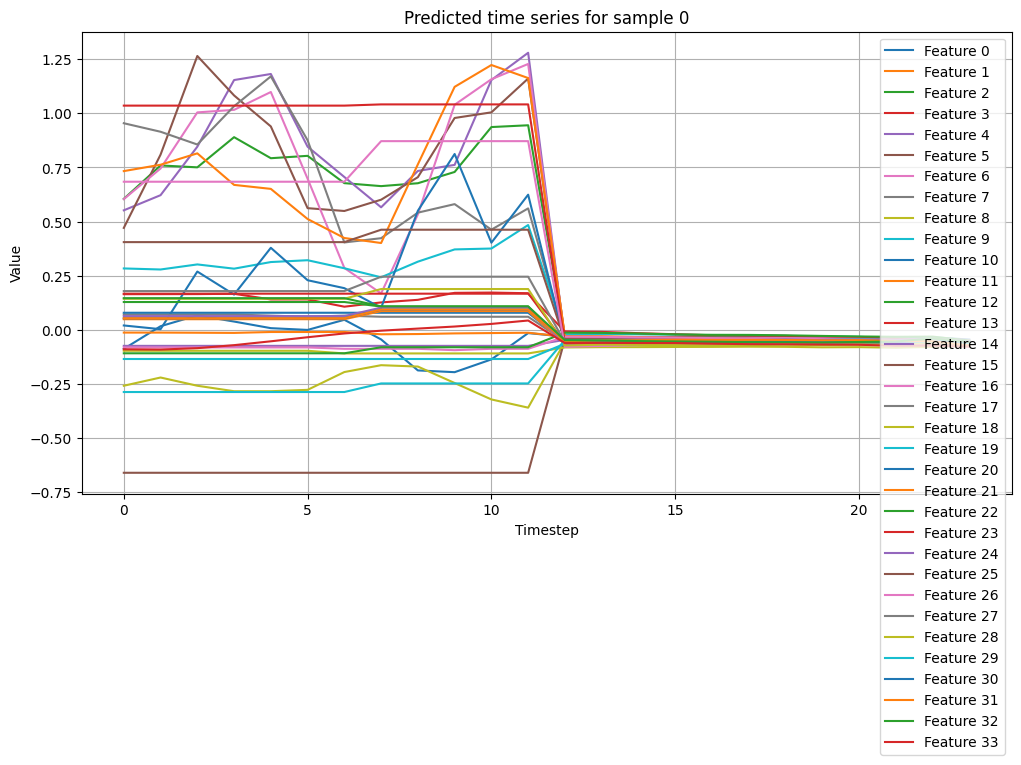

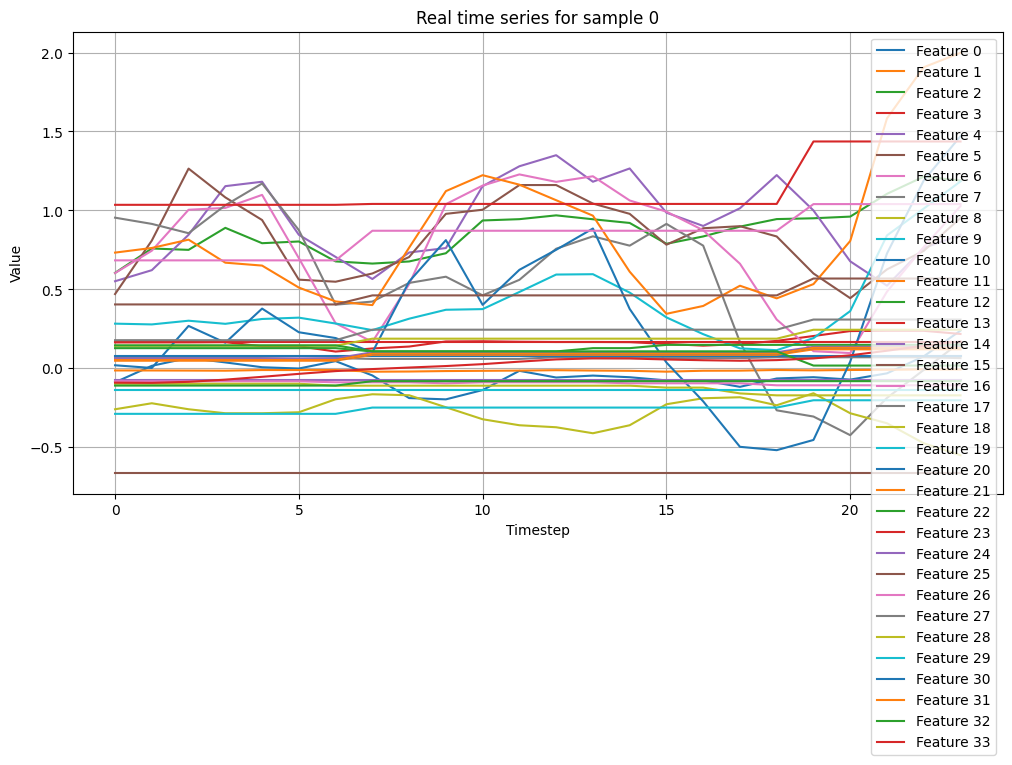

In [34]:
# x: (B, T, D)
B, T, D = 32, 12, 34
sample_idx = 0
x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d], label=f'Feature {d}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.legend()
plt.grid(True)
plt.show()


# Training

In [35]:
# Data augmentation functions

def jitter(x, sigma=0.01):
    noise = torch.randn_like(x) * sigma
    return x + noise

def scaling(x, scale_std=0.1):
    scale = torch.normal(mean=1.0, std=scale_std, size=(x.shape[0], 1, x.shape[2])).to(x.device)
    return x * scale

def time_stretch(x, scale_range=(0.9, 1.1)):
    B, T, C = x.size()
    scale = torch.FloatTensor(B).uniform_(*scale_range).to(x.device)
    stretched = []
    for i in range(B):
        t_len = int(T * scale[i])
        stretched_x = F.interpolate(x[i].unsqueeze(0).permute(0, 2, 1), size=t_len, mode='linear', align_corners=False)
        if t_len > T:
            stretched_x = stretched_x[:, :, :T]  # crop
        else:
            pad_len = T - t_len
            stretched_x = F.pad(stretched_x, (0, pad_len))  # pad
        stretched.append(stretched_x.permute(0, 2, 1))
    return torch.cat(stretched, dim=0)

def masking_augment_fast(x, mask_ratio=0.15, mask_value=0.0):
    mask = torch.bernoulli(torch.full(x.shape[:2], mask_ratio)).bool().to(x.device)
    x = x.clone()
    x[mask] = mask_value
    return x

In [36]:
# class to apply the data augmentations stochastically
class SequentialAugment:
    def __init__(self, augments):
        """
        augments: list of (augment_fn, probability)
        """
        self.augments = augments  

    def __call__(self, x):
        for augment_fn, prob in self.augments:
            if random.random() < prob:  # apply with probability
                x = augment_fn(x)
        return x

augment = SequentialAugment([
    (jitter, 0.7),
    (scaling, 0.5),
    (time_stretch, 0.3),
    # (masking_augment_fast, 0.9)
])

In [70]:
B, orig_len, D = 32, 12, 34
K = 3
C = 16
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
).to(device)

print(f"RATD parameters: {count_parameters(model):,}")

RATD parameters: 230,023


In [71]:
# training function with early stopping

def train_ratd(
    model,
    train_loader,
    encoder=encoder_loaded,
    retrieval_db=retrieval_db,
    k=K,
    val_loader=None,
    orig_len=12,
    epochs=10,
    lr=1e-4,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_path='best_model.pt',
    patience=5,
    drop_prob = 0.5
):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-8
    )
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    start_epoch = 1
    epochs_no_improve = 0  # contatore per early stopping

    # === Recover Checkpoint ===
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Checkpoint found. Restart from epoch {start_epoch} with best_val_loss {best_val_loss:.6f}.")

    for epoch in range(start_epoch, epochs + 1):
        model.train()
        train_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        for x, timestamps, _ in pbar:
            # === Data Augmentation ===
            x = augment(x)
            # retrieve the top-k similar series
            if random.random() < drop_prob:
                xr = None
                x, timestamps = x.to(device), timestamps.to(device)
            else : 
                xr = retrieve_knn(x[:, 0:orig_len, :], encoder, faiss_index, xr_target, k=k, device=device)
                x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)

            optimizer.zero_grad()
            loss, pred = model.calc_loss(x, timestamps, xr=xr)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            mse_loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
            train_loss += mse_loss.item()
            pbar.set_postfix(loss=mse_loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}")

        # === VALIDATION ===
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for x, timestamps, _ in val_loader:
                    xr = retrieve_knn(x[:, 0:orig_len, :], encoder, faiss_index, xr_target, k=k, device=device)
                    x, xr, timestamps = x.to(device), xr.to(device), timestamps.to(device)
                    _, pred = model.calc_loss_validation(x, timestamps, xr=xr)
                    loss = criterion(pred[:, orig_len:, :], x[:, orig_len:, :])
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.6f}")

            scheduler.step(avg_val_loss)

            # === Check improvement for early stopping ===
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss
                }, save_path)
                print(f"Saved best model at {save_path}")
            else:
                epochs_no_improve += 1

            # === Early Stopping ===
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs. Best Val Loss = {best_val_loss:.6f}")
                break

In [72]:
!rm /kaggle/working/models/ratd_best.pt

In [73]:
train_ratd(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=2.5e-4,
    save_path="models/ratd_best.pt",
    drop_prob = 0.0
)

Epoch 1 [Train]: 100%|██████████| 802/802 [00:51<00:00, 15.69it/s, loss=0.155] 


Epoch 1: Train Loss = 0.342977
Epoch 1: Val Loss = 0.215699
Saved best model at models/ratd_best.pt


Epoch 2 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.93it/s, loss=0.0677]


Epoch 2: Train Loss = 0.143088
Epoch 2: Val Loss = 0.157673
Saved best model at models/ratd_best.pt


Epoch 3 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.86it/s, loss=0.0963]


Epoch 3: Train Loss = 0.103439
Epoch 3: Val Loss = 0.134090
Saved best model at models/ratd_best.pt


Epoch 4 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.93it/s, loss=1.5]   


Epoch 4: Train Loss = 0.081008
Epoch 4: Val Loss = 0.115188
Saved best model at models/ratd_best.pt


Epoch 5 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.85it/s, loss=0.0409]


Epoch 5: Train Loss = 0.072380
Epoch 5: Val Loss = 0.101286
Saved best model at models/ratd_best.pt


Epoch 6 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.88it/s, loss=0.0266]


Epoch 6: Train Loss = 0.063298
Epoch 6: Val Loss = 0.094544
Saved best model at models/ratd_best.pt


Epoch 7 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.87it/s, loss=0.0787]


Epoch 7: Train Loss = 0.060491
Epoch 7: Val Loss = 0.089988
Saved best model at models/ratd_best.pt


Epoch 8 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.86it/s, loss=0.0486]


Epoch 8: Train Loss = 0.060080
Epoch 8: Val Loss = 0.086748
Saved best model at models/ratd_best.pt


Epoch 9 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.92it/s, loss=0.0107] 


Epoch 9: Train Loss = 0.049883
Epoch 9: Val Loss = 0.085992
Saved best model at models/ratd_best.pt


Epoch 10 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.94it/s, loss=0.0158] 


Epoch 10: Train Loss = 0.051402
Epoch 10: Val Loss = 0.084789
Saved best model at models/ratd_best.pt


Epoch 11 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.81it/s, loss=0.0141] 


Epoch 11: Train Loss = 0.051936
Epoch 11: Val Loss = 0.093680


Epoch 12 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.83it/s, loss=0.0212] 


Epoch 12: Train Loss = 0.047656
Epoch 12: Val Loss = 0.084928


Epoch 13 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.79it/s, loss=0.105]  


Epoch 13: Train Loss = 0.053867
Epoch 13: Val Loss = 0.089037


Epoch 14 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.81it/s, loss=0.0153] 


Epoch 14: Train Loss = 0.045251
Epoch 14: Val Loss = 0.083914
Saved best model at models/ratd_best.pt


Epoch 15 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.79it/s, loss=0.0669] 


Epoch 15: Train Loss = 0.046609
Epoch 15: Val Loss = 0.087566


Epoch 16 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.81it/s, loss=0.0492] 


Epoch 16: Train Loss = 0.045659
Epoch 16: Val Loss = 0.088025


Epoch 17 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.82it/s, loss=0.00669]


Epoch 17: Train Loss = 0.048097
Epoch 17: Val Loss = 0.087280


Epoch 18 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.83it/s, loss=0.00435]


Epoch 18: Train Loss = 0.040849
Epoch 18: Val Loss = 0.087564


Epoch 19 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.81it/s, loss=0.00464]


Epoch 19: Train Loss = 0.040965
Epoch 19: Val Loss = 0.086876
Early stopping triggered after 19 epochs. Best Val Loss = 0.083914


# Training without reference

We trained the model without using the reference for the generation process, to see how this affect on the quality of the predictions made by the model.

In [53]:
!rm /kaggle/working/models/ratd_best_without_reference.pt

In [54]:
B, orig_len, D = 32, 12, 34
K = 3
C = 16
side_dim = 48
emb_dim = 16
T = orig_len + 12

alt_model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
)

In [ ]:
train_ratd(
    model=alt_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=2.5e-4,
    save_path="models/ratd_best_without_reference.pt",
    drop_prob = 1.0
)

Epoch 1 [Train]: 100%|██████████| 802/802 [00:47<00:00, 16.88it/s, loss=0.175]


Epoch 1: Train Loss = 0.371258
Epoch 1: Val Loss = 0.284856
Saved best model at models/ratd_best_without_reference.pt


Epoch 2 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.40it/s, loss=0.101] 


Epoch 2: Train Loss = 0.210553
Epoch 2: Val Loss = 0.247997
Saved best model at models/ratd_best_without_reference.pt


Epoch 3 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.23it/s, loss=0.164] 


Epoch 3: Train Loss = 0.190614
Epoch 3: Val Loss = 0.236032
Saved best model at models/ratd_best_without_reference.pt


Epoch 4 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.26it/s, loss=0.13]  


Epoch 4: Train Loss = 0.183839
Epoch 4: Val Loss = 0.229805
Saved best model at models/ratd_best_without_reference.pt


Epoch 5 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.29it/s, loss=0.0752]


Epoch 5: Train Loss = 0.175323
Epoch 5: Val Loss = 0.221648
Saved best model at models/ratd_best_without_reference.pt


Epoch 6 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.29it/s, loss=0.0824]


Epoch 6: Train Loss = 0.172429
Epoch 6: Val Loss = 0.217034
Saved best model at models/ratd_best_without_reference.pt


Epoch 7 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.22it/s, loss=0.109] 


Epoch 7: Train Loss = 0.162210
Epoch 7: Val Loss = 0.208909
Saved best model at models/ratd_best_without_reference.pt


Epoch 8 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.27it/s, loss=0.175] 


Epoch 8: Train Loss = 0.158335
Epoch 8: Val Loss = 0.208397
Saved best model at models/ratd_best_without_reference.pt


Epoch 9 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.23it/s, loss=0.168] 


Epoch 9: Train Loss = 0.153368
Epoch 9: Val Loss = 0.204047
Saved best model at models/ratd_best_without_reference.pt


Epoch 10 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.22it/s, loss=0.154] 


Epoch 10: Train Loss = 0.151992
Epoch 10: Val Loss = 0.198263
Saved best model at models/ratd_best_without_reference.pt


Epoch 11 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.24it/s, loss=0.134] 


Epoch 11: Train Loss = 0.148100
Epoch 11: Val Loss = 0.195517
Saved best model at models/ratd_best_without_reference.pt


Epoch 12 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.25it/s, loss=0.11]  


Epoch 12: Train Loss = 0.143640
Epoch 12: Val Loss = 0.190334
Saved best model at models/ratd_best_without_reference.pt


Epoch 13 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.29it/s, loss=0.0729]


Epoch 13: Train Loss = 0.142273
Epoch 13: Val Loss = 0.186464
Saved best model at models/ratd_best_without_reference.pt


Epoch 14 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.31it/s, loss=0.129] 


Epoch 14: Train Loss = 0.131607
Epoch 14: Val Loss = 0.181317
Saved best model at models/ratd_best_without_reference.pt


Epoch 15 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.28it/s, loss=0.148] 


Epoch 15: Train Loss = 0.135101
Epoch 15: Val Loss = 0.178743
Saved best model at models/ratd_best_without_reference.pt


Epoch 16 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.30it/s, loss=0.0576]


Epoch 16: Train Loss = 0.132223
Epoch 16: Val Loss = 0.176076
Saved best model at models/ratd_best_without_reference.pt


Epoch 17 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.28it/s, loss=0.155] 


Epoch 17: Train Loss = 0.133717
Epoch 17: Val Loss = 0.183992


Epoch 18 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.26it/s, loss=0.316] 


Epoch 18: Train Loss = 0.126901
Epoch 18: Val Loss = 0.176432


Epoch 19 [Train]: 100%|██████████| 802/802 [00:46<00:00, 17.27it/s, loss=0.0726]


Epoch 19: Train Loss = 0.124601
Epoch 19: Val Loss = 0.174794
Saved best model at models/ratd_best_without_reference.pt


Epoch 20 [Train]:  47%|████▋     | 378/802 [00:21<00:24, 17.37it/s, loss=0.1]   

In [56]:
train_ratd(
    model=alt_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    lr=2.5e-4,
    save_path="models/ratd_best_without_reference.pt",
    drop_prob = 1.0
)

Checkpoint found. Restart from epoch 21 with best_val_loss 0.173069.


Epoch 21 [Train]: 100%|██████████| 802/802 [00:50<00:00, 15.99it/s, loss=0.127] 


Epoch 21: Train Loss = 0.122004
Epoch 21: Val Loss = 0.174221


Epoch 22 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.35it/s, loss=0.0543]


Epoch 22: Train Loss = 0.128383
Epoch 22: Val Loss = 0.172655
Saved best model at models/ratd_best_without_reference.pt


Epoch 23 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.27it/s, loss=0.0518]


Epoch 23: Train Loss = 0.131622
Epoch 23: Val Loss = 0.165350
Saved best model at models/ratd_best_without_reference.pt


Epoch 24 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.0553]


Epoch 24: Train Loss = 0.124810
Epoch 24: Val Loss = 0.169044


Epoch 25 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.163] 


Epoch 25: Train Loss = 0.116155
Epoch 25: Val Loss = 0.165374


Epoch 26 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.25it/s, loss=0.115] 


Epoch 26: Train Loss = 0.114835
Epoch 26: Val Loss = 0.163145
Saved best model at models/ratd_best_without_reference.pt


Epoch 27 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.27it/s, loss=0.047] 


Epoch 27: Train Loss = 0.116003
Epoch 27: Val Loss = 0.168366


Epoch 28 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.141] 


Epoch 28: Train Loss = 0.115981
Epoch 28: Val Loss = 0.162946
Saved best model at models/ratd_best_without_reference.pt


Epoch 29 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.141] 


Epoch 29: Train Loss = 0.117658
Epoch 29: Val Loss = 0.163827


Epoch 30 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.0545]


Epoch 30: Train Loss = 0.109484
Epoch 30: Val Loss = 0.163795


Epoch 31 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.31it/s, loss=0.0653]


Epoch 31: Train Loss = 0.111261
Epoch 31: Val Loss = 0.169709


Epoch 32 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.28it/s, loss=0.0447]


Epoch 32: Train Loss = 0.110804
Epoch 32: Val Loss = 0.162784
Saved best model at models/ratd_best_without_reference.pt


Epoch 33 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.092] 


Epoch 33: Train Loss = 0.103697
Epoch 33: Val Loss = 0.166079


Epoch 34 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.31it/s, loss=0.0628]


Epoch 34: Train Loss = 0.116146
Epoch 34: Val Loss = 0.155485
Saved best model at models/ratd_best_without_reference.pt


Epoch 35 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.0848]


Epoch 35: Train Loss = 0.105711
Epoch 35: Val Loss = 0.160756


Epoch 36 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.0384]


Epoch 36: Train Loss = 0.101904
Epoch 36: Val Loss = 0.155578


Epoch 37 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.125] 


Epoch 37: Train Loss = 0.110530
Epoch 37: Val Loss = 0.152529
Saved best model at models/ratd_best_without_reference.pt


Epoch 38 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.0663]


Epoch 38: Train Loss = 0.104644
Epoch 38: Val Loss = 0.155763


Epoch 39 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.116] 


Epoch 39: Train Loss = 0.106866
Epoch 39: Val Loss = 0.154207


Epoch 40 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.157] 


Epoch 40: Train Loss = 0.110048
Epoch 40: Val Loss = 0.152355
Saved best model at models/ratd_best_without_reference.pt


Epoch 41 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.0362]


Epoch 41: Train Loss = 0.109900
Epoch 41: Val Loss = 0.152483


Epoch 42 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.0836]


Epoch 42: Train Loss = 0.102036
Epoch 42: Val Loss = 0.157679


Epoch 43 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.0853]


Epoch 43: Train Loss = 0.106852
Epoch 43: Val Loss = 0.152949


Epoch 44 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.0508]


Epoch 44: Train Loss = 0.101119
Epoch 44: Val Loss = 0.151672
Saved best model at models/ratd_best_without_reference.pt


Epoch 45 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.0488]


Epoch 45: Train Loss = 0.097619
Epoch 45: Val Loss = 0.149050
Saved best model at models/ratd_best_without_reference.pt


Epoch 46 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.31it/s, loss=0.121] 


Epoch 46: Train Loss = 0.115359
Epoch 46: Val Loss = 0.148520
Saved best model at models/ratd_best_without_reference.pt


Epoch 47 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.0868]


Epoch 47: Train Loss = 0.098996
Epoch 47: Val Loss = 0.149543


Epoch 48 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.0502]


Epoch 48: Train Loss = 0.093745
Epoch 48: Val Loss = 0.149416


Epoch 49 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.111] 


Epoch 49: Train Loss = 0.099880
Epoch 49: Val Loss = 0.147503
Saved best model at models/ratd_best_without_reference.pt


Epoch 50 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.0538]


Epoch 50: Train Loss = 0.093984
Epoch 50: Val Loss = 0.149396


Epoch 51 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.106] 


Epoch 51: Train Loss = 0.101107
Epoch 51: Val Loss = 0.147690


Epoch 52 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.0644]


Epoch 52: Train Loss = 0.099566
Epoch 52: Val Loss = 0.147132
Saved best model at models/ratd_best_without_reference.pt


Epoch 53 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.0541]


Epoch 53: Train Loss = 0.103793
Epoch 53: Val Loss = 0.146820
Saved best model at models/ratd_best_without_reference.pt


Epoch 54 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.28it/s, loss=0.188] 


Epoch 54: Train Loss = 0.097616
Epoch 54: Val Loss = 0.148111


Epoch 55 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.31it/s, loss=0.101] 


Epoch 55: Train Loss = 0.095084
Epoch 55: Val Loss = 0.145302
Saved best model at models/ratd_best_without_reference.pt


Epoch 56 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.31it/s, loss=0.0339]


Epoch 56: Train Loss = 0.095308
Epoch 56: Val Loss = 0.147312


Epoch 57 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.097] 


Epoch 57: Train Loss = 0.095236
Epoch 57: Val Loss = 0.146384


Epoch 58 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.0418]


Epoch 58: Train Loss = 0.110769
Epoch 58: Val Loss = 0.146756


Epoch 59 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.28it/s, loss=0.113] 


Epoch 59: Train Loss = 0.107102
Epoch 59: Val Loss = 0.143842
Saved best model at models/ratd_best_without_reference.pt


Epoch 60 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.32it/s, loss=0.138] 


Epoch 60: Train Loss = 0.096613
Epoch 60: Val Loss = 0.144956


Epoch 61 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.0504]


Epoch 61: Train Loss = 0.098945
Epoch 61: Val Loss = 0.143781
Saved best model at models/ratd_best_without_reference.pt


Epoch 62 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.121] 


Epoch 62: Train Loss = 0.103032
Epoch 62: Val Loss = 0.144525


Epoch 63 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.30it/s, loss=0.0676]


Epoch 63: Train Loss = 0.097558
Epoch 63: Val Loss = 0.145767


Epoch 64 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.33it/s, loss=0.0717]


Epoch 64: Train Loss = 0.098734
Epoch 64: Val Loss = 0.144481


Epoch 65 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.28it/s, loss=0.0915]


Epoch 65: Train Loss = 0.104959
Epoch 65: Val Loss = 0.142741
Saved best model at models/ratd_best_without_reference.pt


Epoch 66 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.34it/s, loss=0.107] 


Epoch 66: Train Loss = 0.098044
Epoch 66: Val Loss = 0.144688


Epoch 67 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.29it/s, loss=0.0296]


Epoch 67: Train Loss = 0.094429
Epoch 67: Val Loss = 0.143806


Epoch 68 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.31it/s, loss=0.0515]


Epoch 68: Train Loss = 0.089179
Epoch 68: Val Loss = 0.144378


Epoch 69 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.28it/s, loss=0.0498]


Epoch 69: Train Loss = 0.101793
Epoch 69: Val Loss = 0.142857


Epoch 70 [Train]: 100%|██████████| 802/802 [00:49<00:00, 16.24it/s, loss=0.0236]


Epoch 70: Train Loss = 0.097760
Epoch 70: Val Loss = 0.143385
Early stopping triggered after 70 epochs. Best Val Loss = 0.142741


<img src="ref_eff_on_model_training.png">

# Results

In [82]:
B, orig_len, D = 32, 12, 34
K = 3
C = 16
side_dim = 48
emb_dim = 16
T = orig_len + 12

model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
).to(device)

alt_model = RATD(
    input_dim=D,
    channels=C,
    context_dim=K,
    side_dim=side_dim,
    emb_dim=emb_dim,
    original_len=orig_len,
    seq_len=T,
    n_layers=3
).to(device)

In [83]:
checkpoint = torch.load("models/ratd_best.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

checkpoint = torch.load("models/ratd_best_without_reference.pt", map_location=device)
alt_model.load_state_dict(checkpoint['model_state_dict'])
alt_model.eval()

RATD(
  (ldte): LearnableDiffusionTimestepEmbedding(
    (embedding): Embedding(20, 16)
  )
  (side_module): SideInformation()
  (layers): ModuleList(
    (0-2): 3 x RATDLayer(
      (rma): RMA(
        (q_proj): Linear(in_features=34, out_features=32, bias=True)
        (k_proj): Linear(in_features=68, out_features=32, bias=True)
        (v_proj): Linear(in_features=102, out_features=32, bias=True)
        (out): Linear(in_features=32, out_features=34, bias=True)
      )
      (time_feature_conv): CausalConv2d(
        (conv): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (diff_timestep_emb_conv): Conv1d(16, 384, kernel_size=(3,), stride=(1,), padding=(1,))
      (ln): LayerNorm((16, 24, 34), eps=1e-05, elementwise_affine=True)
      (temporal_transformer): TemporalTransformer(
        (transformer): LinearAttentionTransformer(
          (layers): SequentialSequence(
            (layers): ModuleList(
              (0): ModuleList(
                (0):

In [84]:
for xb, timestamps, _ in test_loader:
    break
xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
xb, xr, timestamps= xb.to(device), xr.to(device), timestamps.to(device)
x_in = xb.detach().clone()
x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
output = model(x_in, timestamps, xr)
alt_output = alt_model(x_in, timestamps)

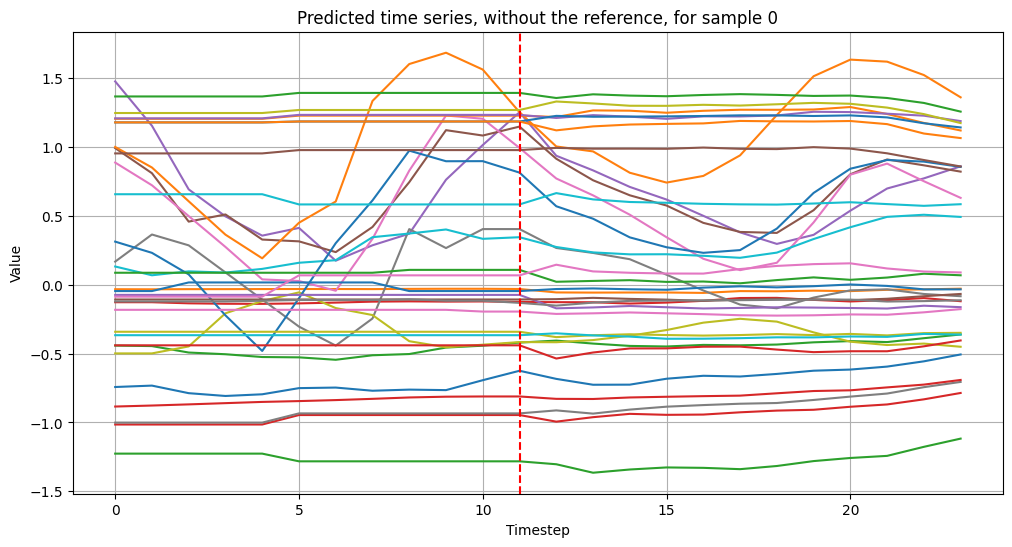

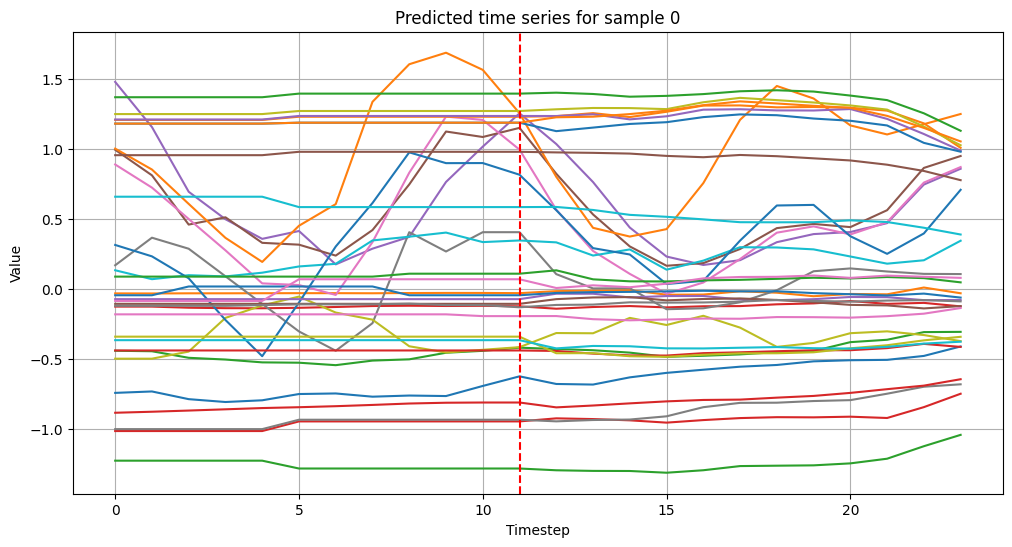

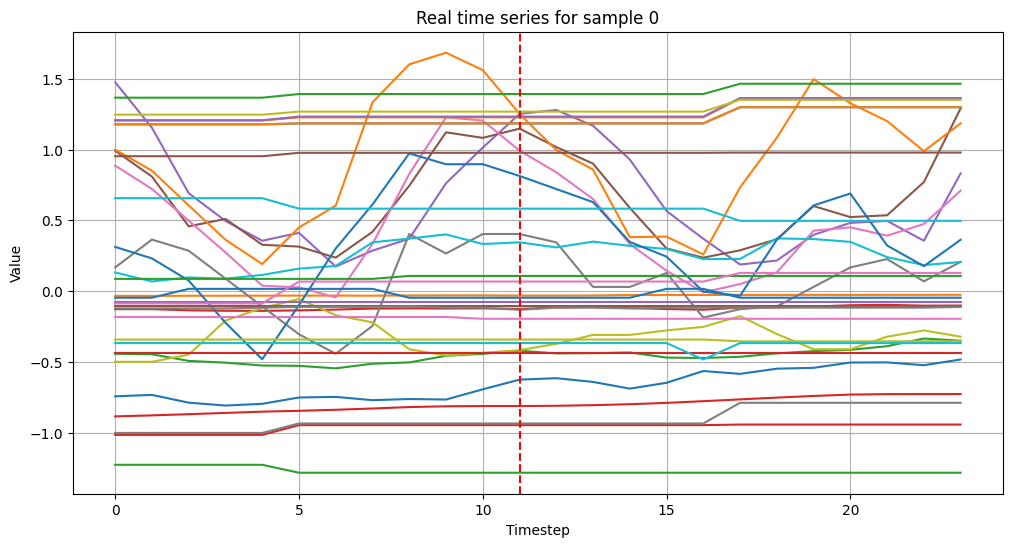

In [85]:
# x: (B, T, D)
B, T, D = 32, 14, 34
# for sample_idx in range(B):
sample_idx = 0

x_sample = alt_output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series, without the reference, for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in range(D):
    plt.plot(x_sample[:, d])
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.grid(True)
plt.show()

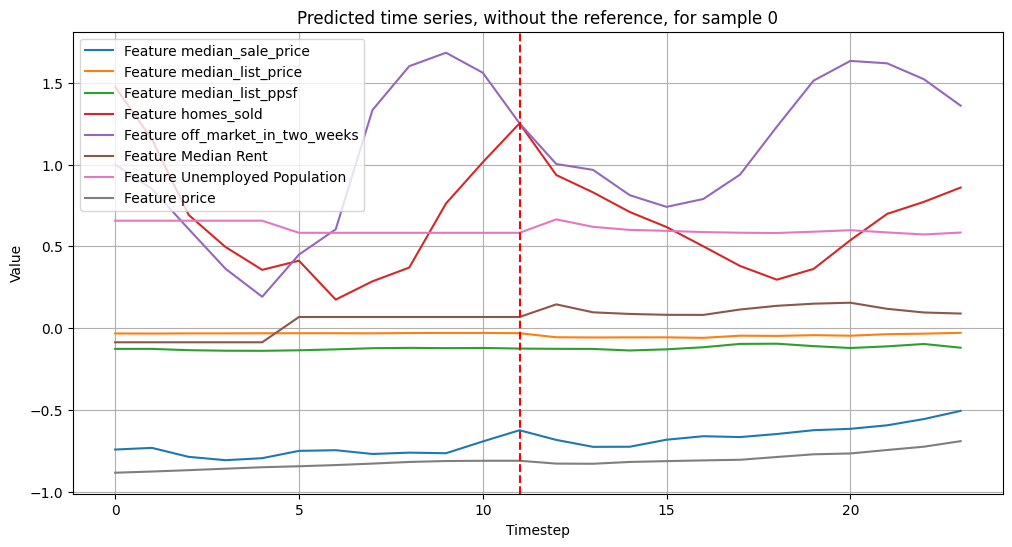

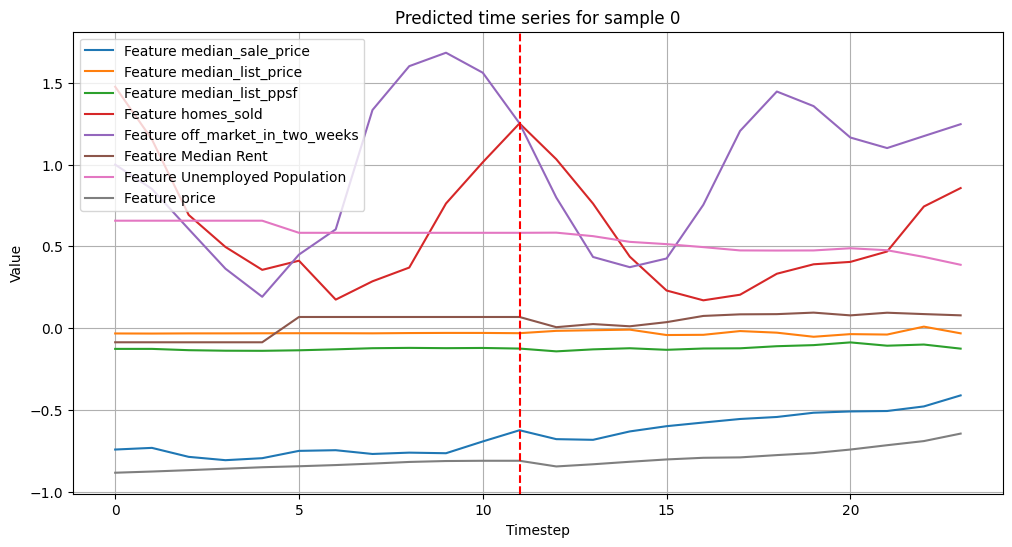

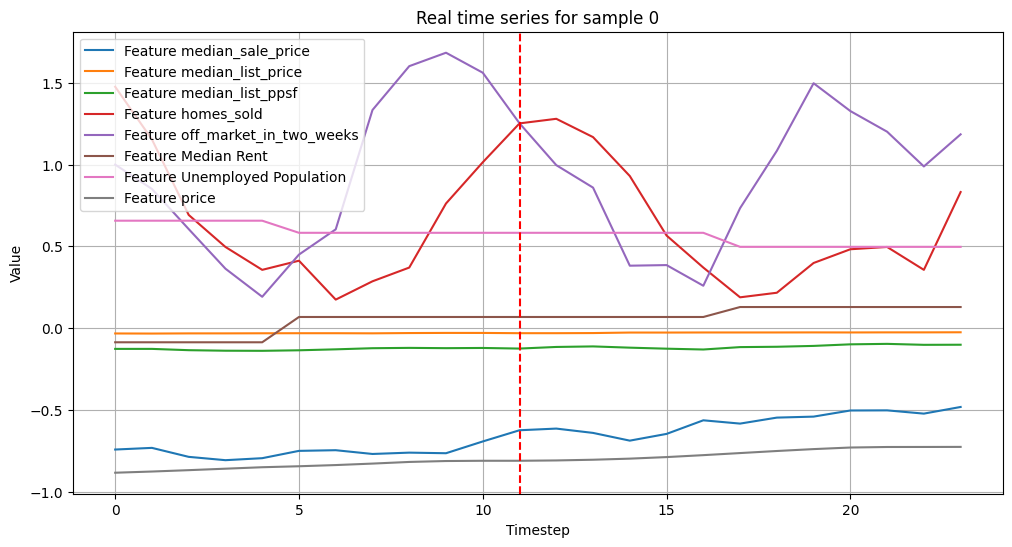

In [86]:
# x: (B, T, D)
B, T, D = 32, 14, 34
# for sample_idx in range(B):
sample_idx = 0

relevant_features_indeces = [0, 1, 3, 4, 11, 26, 29, 33]

x_sample = alt_output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series, without the reference, for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

x_sample = output.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Predicted time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

x_sample = xb.cpu()[sample_idx].detach().numpy()  # shape: (T, D)

plt.figure(figsize=(12, 6))
for d in relevant_features_indeces:
    plt.plot(x_sample[:, d], label=f'Feature {feature_index_mapping[d]}')
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.title(f"Real time series for sample {sample_idx}")
plt.axvline(x=11, color='red', linestyle='--')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

The visual and statistical (0.084 vs 0.143 of MSE) results acknowledge the improvement brought by the guidance of a reference during the generation process.

In [87]:
class RMSLE(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        # Assicurati che non ci siano valori negativi (clip a 0)
        y_pred = torch.clamp(y_pred, min=0)
        y_true = torch.clamp(y_true, min=0)

        # Calcolo RMSLE
        log_pred = torch.log1p(y_pred)  # log(1 + y_pred)
        log_true = torch.log1p(y_true)  # log(1 + y_true)

        return torch.sqrt(torch.mean((log_pred - log_true) ** 2))

In [88]:
test_loss = 0
metric = RMSLE()   

with torch.no_grad():
    for xb, timestamps, _ in test_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device)
        x_in = xb.detach().clone()
        x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
        output = model(x_in, timestamps, xr)

        test_loss += metric(output, xb).item()

print("Test RMSLE:", test_loss / len(test_loader))


val_loss = 0
metric = RMSLE()   

with torch.no_grad():
    for xb, timestamps, _ in val_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device)
        x_in = xb.detach().clone()
        x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
        output = model(x_in, timestamps, xr)

        val_loss += metric(output, xb).item()

print("Validation RMSLE:", val_loss / len(val_loader))


Test RMSLE: 0.05945058427751064
Validation RMSLE: 0.05965788785530173


In [89]:
criterion = nn.MSELoss()
test_loss_per_feature = torch.zeros(34)
test_loss = 0

with torch.no_grad():
    for xb, timestamps, _ in test_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device)
        x_in = xb.detach().clone()
        x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
        output = model(x_in, timestamps, xr)

        batch_loss = 0
        for i in range(34):
            loss = criterion(output[:, orig_len:, i], xb[:, orig_len:, i])
            loss_value = loss.item()
            test_loss_per_feature[i] += loss_value
            batch_loss += loss_value
        
        test_loss += batch_loss / 34  # Average per feature, per batch

avg_test_loss = test_loss / len(test_loader)
test_loss_per_feature = test_loss_per_feature / len(test_loader)

In [90]:
print(f"Test MSE = {avg_test_loss:.6f}")

Test MSE = 0.079143


In [91]:
criterion = nn.MSELoss()
val_loss_per_feature = torch.zeros(34)
val_loss = 0

with torch.no_grad():
    for xb, timestamps, _ in val_loader:
        xr = retrieve_knn(xb[:, 0:orig_len, :], encoder_loaded, faiss_index, xr_target, k=3, device=device)
        xb, xr, timestamps = xb.to(device), xr.to(device), timestamps.to(device)
        x_in = xb.detach().clone()
        x_in[:, 12:, :] = torch.randn_like(x_in[:, 12:, :])
        output = model(x_in, timestamps, xr)

        batch_loss = 0
        for i in range(34):
            loss = criterion(output[:, orig_len:, i], xb[:, orig_len:, i])
            loss_value = loss.item()
            val_loss_per_feature[i] += loss_value
            batch_loss += loss_value
        
        val_loss += batch_loss / 34  # Average per feature, per batch

avg_val_loss = val_loss / len(val_loader)
val_loss_per_feature = val_loss_per_feature / len(val_loader)

In [92]:
print(f"Val MSE = {avg_val_loss:.6f}")

Val MSE = 0.083899


In [93]:
mean_values = mean[0][0].tolist()
std_values = std[0][0].tolist()
test_mse_values = test_loss_per_feature.tolist()
val_mse_values = val_loss_per_feature.tolist()

# Create a DataFrame
data = []
for i in range(len(feature_index_mapping)):
    row = {
        'Feature': feature_index_mapping[i],
        'Mean': round(mean_values[i], 4),
        'Std': round(std_values[i], 4),
        'Test MSE': round(test_mse_values[i], 4),
        'Val MSE': round(val_mse_values[i], 4)
    }
    data.append(row)

df = pd.DataFrame(data, columns=["Feature", "Mean", "Std", "Test MSE", "Val MSE"])

df = df.sort_values(by=["Test MSE", "Val MSE"], ascending=[False, False]).reset_index(drop=True)

# Visualize
styled = df.style.set_caption("Feature-Level Summary Statistics") \
                 .format("{:.4f}", subset=["Mean", "Std", "Test MSE", "Val MSE"]) \
                 .background_gradient(subset=["Test MSE", "Val MSE"], cmap="Reds") \
                 .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])

display(styled)

,Feature,Mean,Std,Test MSE,Val MSE
0,median_list_price,559273.7070,8929021.6001,0.5330,0.5731
1,avg_sale_to_list,0.9884,0.0317,0.3987,0.3995
2,median_dom,54.4115,78.9979,0.3525,0.3870
3,sold_above_list,0.2714,0.1921,0.3371,0.3183
4,off_market_in_two_weeks,0.3191,0.2467,0.2076,0.2119
5,median_sale_price,453616.9734,245820.7292,0.1950,0.1895
6,median_list_ppsf,244.4712,561.0436,0.1858,0.2846
7,median_ppsf,227.0334,115.0888,0.0651,0.0770
8,new_listings,81.7360,84.8837,0.0569,0.0522
9,inventory,50.4805,50.8368,0.0414,0.0405


In [94]:
csv_file = "/kaggle/input/housets/HouseTS_with_images.csv"

thresholds = [5.6e6, 5e7, 9e8] # mean for median_list_price

for threshold in thresholds:
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Ensure the column exists
    if 'median_list_price' not in df.columns:
        raise ValueError("The column 'median_list_price' was not found in the CSV file.")

    # Count how many rows have median_list_price > threshold
    count_high_price = (df['median_list_price'] > threshold).sum()

    print(f"Number of rows with 'median_list_price' > {threshold}: {count_high_price}")


Number of rows with 'median_list_price' > 5600000.0: 18
Number of rows with 'median_list_price' > 50000000.0: 6
Number of rows with 'median_list_price' > 900000000.0: 3


The performance was measured using the Mean Squared Error (MSE) metric. On the validation set, the model achieved a MSE of 0.084, while on the test set it achieved a slightly lower MSE of 0.082, indicating good generalization capabilities. A more detailed analysis revealed that, among all features, only one, the median_list_price, exhibited a significantly higher error, with a MSE of approximately 0.86 on the test set. Notably, this particular feature also had a standard deviation more than ten times larger than its onw mean, there were some outliers that made difficult to generalize on this feature, while other features presented a standard deviation close to or lower than the mean.
Overall, the results indicate robust performance across most features, with the exception of the outlier feature influenced by its inherent statistical characteristics.

# Final Considerations

The results obtained in our experiments are promising and show comparable performance to those reported in the reference paper. Specifically, despite working with a similar number of features, our model achieved prediction errors in a similar range, indicating that our architecture and preprocessing pipeline were effective. While we attempted to replicate the experimental conditions as closely as possible, including the use of publicly available platforms such as Kaggle for training, it is important to note that we did not have access to the same computational resources as the original study. This limitation may have affected training duration, batch size, and model complexity. Nevertheless, the similarity in the results suggests that our implementation closely resembles the original approach, both in design and in effectiveness, reinforcing the validity of our experimental setup.